In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Imputing missing values and scaling values
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer


# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
# Read in data into dataframes
train_features = pd.read_csv('data/train_features.csv')
test_features = pd.read_csv('data/test_featuers.csv')
train_labels = pd.read_csv('data/train_labels.csv')
test_labels = pd.read_csv('data/test_labels.csv')

train_features = train_features.drop(train_features.columns[[0]], axis=1)
test_features = test_features.drop(test_features.columns[[0]], axis=1)
train_labels = train_labels.drop(train_labels.columns[[0]], axis=1)
test_labels = test_labels.drop(test_labels.columns[[0]], axis=1)

# Display sizes of data
print('Training Feature Size: ', train_features.shape)
print('Testing Feature Size:  ', test_features.shape)
print('Training Labels Size:  ', train_labels.shape)
print('Testing Labels Size:   ', test_labels.shape)

Training Feature Size:  (5607, 64)
Testing Feature Size:   (2403, 64)
Training Labels Size:   (5607, 1)
Testing Labels Size:    (2403, 1)


Заполняем отсутствующие значения
Хотя при очистке данных мы отбросили колонки, в которых не хватает больше половины значений, у нас ещё отсутствует немало значений, поэтому нам нужно их заполнить.

В нижеприведённом коде мы создадим Scikit-Learn-объект SimpleImputer с медианной стратегией. Затем обучим его на обучающих данных , и применим для заполнения отсутствующих значений в обучающем и тестовом наборах. То есть записи, которых не хватает в тестовых данных, будут заполняться соответствующим медианным значением из обучающих данных.


In [3]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

In [4]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


Выполним масштабирование, приводя каждое значение к диапазону от 0 до 1. Берём все значения признака, выбираем минимальное и делим его на разницу между максимальным и минимальным (диапазон).

In [5]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [6]:
# Convert y to one-dimensional array (vector)
y = np.array(train_labels).reshape((-1, ))
y_test = np.array(test_labels).reshape((-1, ))

Для начала сравним несколько модулей машинного обучения, и выберем наиболе подходящий.
Для сравнения используем функцию нахождения средней абсолютной ошибки (чем меньше значение, тем лучше).

In [7]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):

    # Train the model
    model.fit(X, y)

    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)

    # Return the performance metric
    return model_mae

In [8]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 19653885216269488.0000


In [9]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 1914313.1236


In [10]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 67345.8981


In [11]:
gradient_boosted = GradientBoostingRegressor(random_state=60)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 152390.3361


In [12]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 1272521.8251


Предварительно уже видно, что лучше всех справилась модель случайный лес. Дальше будем использовать её.

Можем представить зполученные значений в графике:

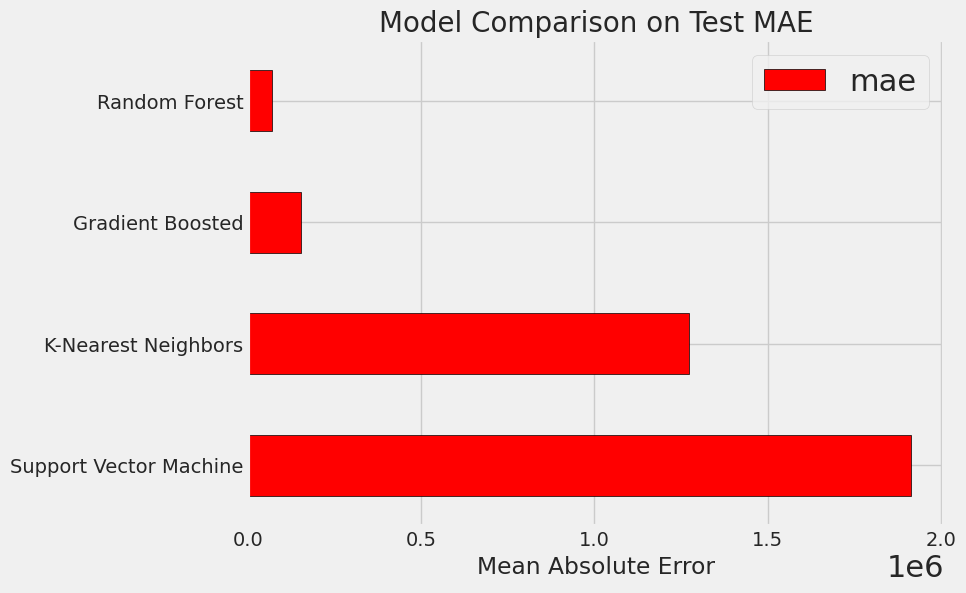

In [13]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Support Vector Machine',
                                           'Random Forest', 'Gradient Boosted',
                                            'K-Nearest Neighbors'],
                                 'mae': [svm_mae, random_forest_mae,
                                         gradient_boosted_mae, knn_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'red', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

Теперь нам нужно выбрать гиперпараметры для модели.
Будем использовать метод случайного поиска с перекрёстной проверкой.



В этом коде мы создаём сетку из гиперпараметров, затем создаём объект RandomizedSearchCV и ищем с помощью 4-блочной перекрёстной проверки по 25 разным комбинациям гиперпараметров:

In [14]:
# Criterion function to be optimized
criterion = ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['sqrt', 'log2', 1.0]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'criterion': criterion,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [15]:
# Create the model to use for hyperparameter tuning
model = RandomForestRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25,
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1,
                               return_train_score = True,
                               random_state=42)

In [16]:
# Fit on the training data
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error',
                                                      'friedman_mse',
                                                      'poisson'],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'max_features': ['sqrt', 'log2', 1.0],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 4, 6, 10],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=1)

In [17]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
9,33.335212,1.578695,0.212256,0.052778,500,4,2,1.0,15,friedman_mse,"{'n_estimators': 500, 'min_samples_split': 4, ...",-80110.202049,-70213.133011,-81437.933605,-73325.662325,-76271.732747,4658.579171,1,-33759.632090,-32955.392298,-33975.290597,-33657.000384,-33586.828842,382.230183
13,2130.805060,30.520462,0.571099,0.141147,1500,10,1,1.0,15,absolute_error,"{'n_estimators': 1500, 'min_samples_split': 10...",-100590.436260,-94461.617259,-102942.860261,-95129.731064,-98281.161211,3591.121595,2,-55612.110715,-58197.856692,-58188.629055,-57964.933385,-57490.882462,1088.711443
18,27.706727,1.566329,0.135989,0.015076,500,6,1,1.0,10,poisson,"{'n_estimators': 500, 'min_samples_split': 6, ...",-108976.076354,-100272.012107,-109053.904389,-97220.252180,-103880.561257,5246.644100,3,-68044.640994,-70450.336360,-68376.662466,-64962.207313,-67958.461783,1960.184840
22,61.934767,1.263664,0.461088,0.169536,1500,2,8,1.0,10,squared_error,"{'n_estimators': 1500, 'min_samples_split': 2,...",-119148.269646,-103371.288469,-117140.792854,-104855.657353,-111129.002081,7070.842509,4,-85786.282162,-84208.536978,-84453.431669,-83280.621196,-84432.218001,895.844319
17,494.892492,1.482542,0.108188,0.035010,500,6,8,1.0,5,absolute_error,"{'n_estimators': 500, 'min_samples_split': 6, ...",-533554.550174,-520814.641428,-530688.555563,-490242.773792,-518825.130239,17165.415280,5,-483072.366206,-495279.346842,-488016.072889,-486775.767347,-488285.888321,4428.389681
0,3.172326,0.592217,0.025794,0.006203,100,2,6,1.0,5,squared_error,"{'n_estimators': 100, 'min_samples_split': 2, ...",-553135.864053,-526851.540501,-525889.375285,-508222.214942,-528524.748695,16028.448885,6,-486260.685250,-503715.568690,-498910.568392,-502913.689312,-497950.127911,6990.042289
20,14.961005,0.809880,0.116253,0.036349,500,6,1,1.0,5,poisson,"{'n_estimators': 500, 'min_samples_split': 6, ...",-617772.745875,-606240.208215,-590340.681903,-548713.129659,-590766.691413,26160.276376,7,-563922.665060,-575736.557349,-561788.883159,-547715.850524,-562290.989023,9951.538158
8,44.993672,1.532459,0.273882,0.092172,1500,6,2,1.0,5,poisson,"{'n_estimators': 1500, 'min_samples_split': 6,...",-617769.817883,-606342.360030,-588107.226207,-551689.382226,-590977.196587,25028.493216,8,-565658.959590,-575904.788863,-560083.693487,-550559.844133,-563051.821518,9176.808017
1,3.172289,0.745524,0.018683,0.003563,100,6,8,1.0,5,poisson,"{'n_estimators': 100, 'min_samples_split': 6, ...",-624604.640761,-607416.040542,-590787.309821,-546532.526190,-592335.129328,29021.670570,9,-568475.027518,-575505.984903,-563178.681447,-545617.372851,-563194.266680,11050.025794
6,20.826303,0.184128,0.469714,0.017934,1500,6,2,sqrt,15,poisson,"{'n_estimators': 1500, 'min_samples_split': 6,...",-745474.318168,-697700.993451,-695611.821151,-697443.263190,-709057.598990,21040.625364,10,-499144.671982,-496951.353141,-499839.868156,-500249.125786,-499046.254766,1272.302997


In [18]:
random_cv.best_estimator_

RandomForestRegressor(criterion='friedman_mse', max_depth=15,
                      min_samples_leaf=2, min_samples_split=4, n_estimators=500,
                      random_state=42)

In [19]:
# Create parametrs to evaluete
p_grid = {'n_estimators': [500, 600, 700, 800],
          'min_samples_split': [4, 5],}

model = RandomForestRegressor(criterion='friedman_mse',
                              max_depth=15,
                              min_samples_leaf=2,
                              max_features=1.0,
                              random_state=42)

# Random Forest Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, param_grid=p_grid, cv = 4,
                           scoring = 'neg_mean_absolute_error', verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [20]:
# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


GridSearchCV(cv=4,
             estimator=RandomForestRegressor(criterion='friedman_mse',
                                             max_depth=15, min_samples_leaf=2,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'min_samples_split': [4, 5],
                         'n_estimators': [500, 600, 700, 800]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [21]:
grid_search.best_estimator_

RandomForestRegressor(criterion='friedman_mse', max_depth=15,
                      min_samples_leaf=2, min_samples_split=4, n_estimators=800,
                      random_state=42)

График зависимости количества деревьев от средней абсолютной ошибки.

In [ ]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees');

Из графика видно, что с увеличением количества деревьев решений результут улучшается.

Дальше будем использовать лучшую модель для прогнозирования цены квартиры.


In [26]:
# Default model
default_model = RandomForestRegressor(random_state = 42)

# Select the best model
final_model = grid_search.best_estimator_


Сравним базовую и финальную модель:

In [27]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

6.52 s ± 1.2 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [28]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

44.2 s ± 4.52 s per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [29]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 66521.0550.
Final model performance on the test set:   MAE = 64299.9828.


Наша модель лучше на 3%, но в 7 раз медленнее. Увеличение времени не так важно, так что останемся с финальной моделью.

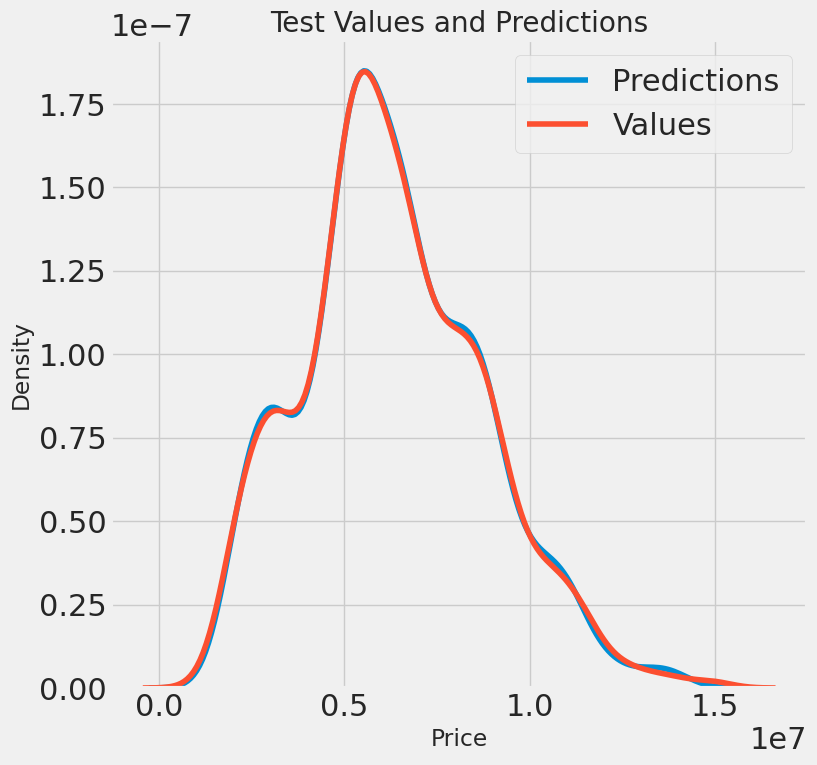

In [31]:
# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.legend()
plt.xlabel('Price'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

График показывает, что модель довольно успешно предсказывает цену.

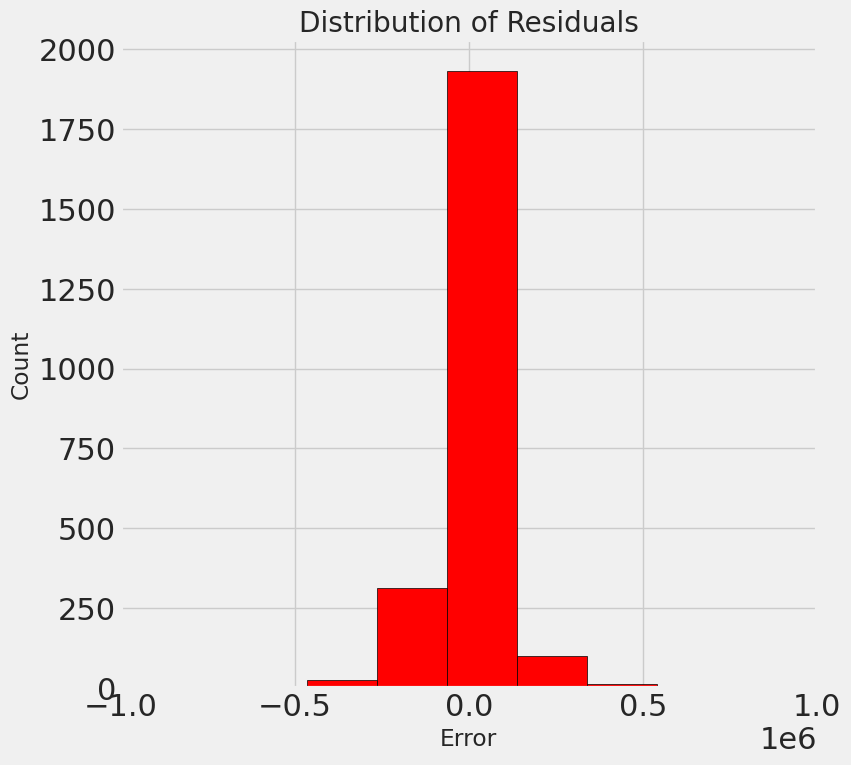

In [32]:
figsize = (6, 6)

# Calculate the residuals
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlim([-1000000, 1000000])
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals');